# Data Science Challenge

For this challenge we will use a fake credit card dataset that is attached as df.csv , which
includes information from a public Kaggle dataset with three added fields: activated_date ,
last_payment_date and fraud

### Importing libraries and dataset

In [185]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from statistics import mode
from scipy.stats import ttest_ind, chi2_contingency, normaltest

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, roc_auc_score, recall_score, precision_score, f1_score

from sklearn.preprocessing import OneHotEncoder

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import RidgeClassifier
from lightgbm import LGBMClassifier

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier

import tensorflow as tf
from sklearn.model_selection import GridSearchCV

In [108]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [109]:
df = pd.read_csv('/content/drive/MyDrive/Stori_Data_Challenge_2021.csv', index_col = 0)

In [110]:
df.head(5)

,cust_id,activated_date,last_payment_date,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,purchases_frequency,oneoff_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,cash_advance_trx,purchases_trx,credit_limit,payments,minimum_payments,prc_full_payment,tenure,fraud
1,C10001,2019-10-06,2020-09-09,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12,0
2,C10002,2019-10-06,2020-07-04,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12,0
3,C10003,2019-10-06,2020-09-17,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12,0
4,C10004,2019-10-06,2020-08-24,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12,0
5,C10005,2019-10-06,2020-10-20,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12,0


In [111]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8950 entries, 1 to 8950
Data columns (total 21 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   cust_id                           8950 non-null   object 
 1   activated_date                    8937 non-null   object 
 2   last_payment_date                 8941 non-null   object 
 3   balance                           8948 non-null   float64
 4   balance_frequency                 8950 non-null   float64
 5   purchases                         8950 non-null   float64
 6   oneoff_purchases                  8950 non-null   float64
 7   installments_purchases            8950 non-null   float64
 8   cash_advance                      8838 non-null   float64
 9   purchases_frequency               8950 non-null   float64
 10  oneoff_purchases_frequency        8950 non-null   float64
 11  purchases_installments_frequency  8950 non-null   float64
 12  cash_a

We can see that there are several columns with null values

### Null Values

In [112]:
columns = list(df.columns)
columns  = list( set(columns) - {'activated_date', 'last_payment_date', 'cust_id'} )
columns

['tenure',
 'fraud',
 'minimum_payments',
 'purchases_trx',
 'credit_limit',
 'oneoff_purchases',
 'prc_full_payment',
 'cash_advance_frequency',
 'payments',
 'purchases',
 'purchases_frequency',
 'installments_purchases',
 'balance_frequency',
 'cash_advance_trx',
 'purchases_installments_frequency',
 'cash_advance',
 'oneoff_purchases_frequency',
 'balance']

##### Treatment of null values

We are going to remove the entire row with null values in columns 'activated_date' and 'last_payment_date' for the rest of the columns with null values we are going to replace them with the average value of the respective column.

In [113]:
for column in columns:
  if df[column].isna().value_counts().to_frame().loc[False, ].values[0] != 8950:
    df[column].fillna( df[column].mean(), inplace = True )

In [114]:
df.dropna(inplace = True)


In [115]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 8928 entries, 1 to 8950
Data columns (total 21 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   cust_id                           8928 non-null   object 
 1   activated_date                    8928 non-null   object 
 2   last_payment_date                 8928 non-null   object 
 3   balance                           8928 non-null   float64
 4   balance_frequency                 8928 non-null   float64
 5   purchases                         8928 non-null   float64
 6   oneoff_purchases                  8928 non-null   float64
 7   installments_purchases            8928 non-null   float64
 8   cash_advance                      8928 non-null   float64
 9   purchases_frequency               8928 non-null   float64
 10  oneoff_purchases_frequency        8928 non-null   float64
 11  purchases_installments_frequency  8928 non-null   float64
 12  cash_a

We can see that there are no more null values.

In [117]:
df.duplicated().value_counts()


False    8928
dtype: int64

No duplicate rows either.

### Feature Engineering

In [116]:
df.describe()

,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,purchases_frequency,oneoff_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,cash_advance_trx,purchases_trx,credit_limit,payments,minimum_payments,prc_full_payment,tenure,fraud
count,8928.000000,8928.000000,8928.000000,8928.000000,8928.00000,8928.000000,8928.000000,8928.000000,8928.000000,8928.000000,8928.000000,8928.000000,8928.000000,8928.000000,8928.000000,8928.000000,8928.000000,8928.000000
mean,1565.722926,0.877180,1002.657567,591.941529,411.01696,979.762533,0.490299,0.202285,0.364477,0.135095,3.250224,14.711358,4492.890074,1732.338753,864.442788,0.153604,11.516801,0.007841
std,2082.682567,0.236981,2134.333868,1658.517410,904.50125,2088.193311,0.401437,0.298294,0.397487,0.199999,6.828345,24.878914,3637.088681,2894.626765,2332.603243,0.292370,1.338501,0.088204
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.019163,0.000000,6.000000,0.000000
25%,128.372855,0.888889,39.000000,0.000000,0.00000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,383.089845,170.892064,0.000000,12.000000,0.000000
50%,873.942013,1.000000,360.825000,37.400000,89.00000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,856.901546,335.628312,0.000000,12.000000,0.000000
75%,2057.408524,1.000000,1111.190000,576.555000,468.73750,1097.846510,0.916667,0.300000,0.750000,0.222222,4.000000,17.000000,6500.000000,1899.978541,864.173246,0.142857,12.000000,0.000000
max,19043.138560,1.000000,49039.570000,40761.250000,22500.00000,47137.211760,1.000000,1.000000,1.000000,1.500000,123.000000,358.000000,30000.000000,50721.483360,76406.207520,1.000000,12.000000,1.000000


We see that there are several columns with outliers and probabily many of them are correlated each other.

#### Correlations

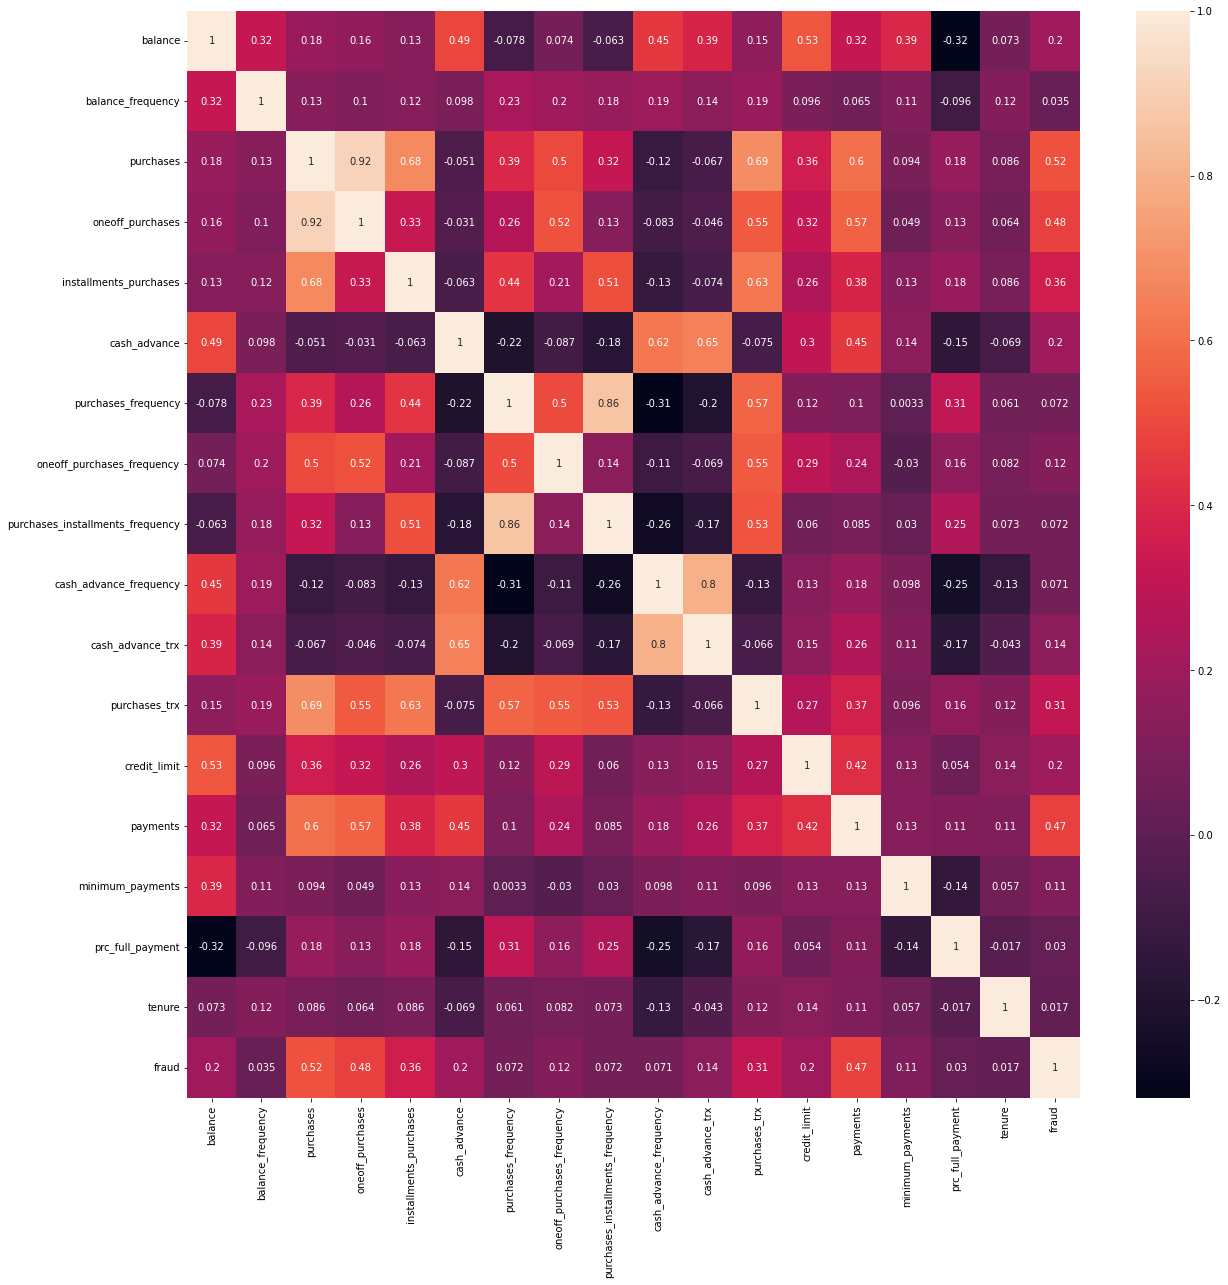

In [118]:
correlations = df.corr()
f, ax = plt.subplots( figsize = ( 20, 20 ) ) #Donde hay 1 son las variables con mayor correlacion
sns.heatmap( correlations, annot = True )
plt.show()

In fact, we can see that there are some columns correlated with others. 
* 'oneoff_purchases' <---> 'purchases'
* 'purchases_installments_frequency' <-----> 'purchases_frequency'
* 'cash_advance_trx' <------> 'cash_advance_frequency'

So, we should not consider these redundant columns.

Now we will make a histogram of each column to see its behavior

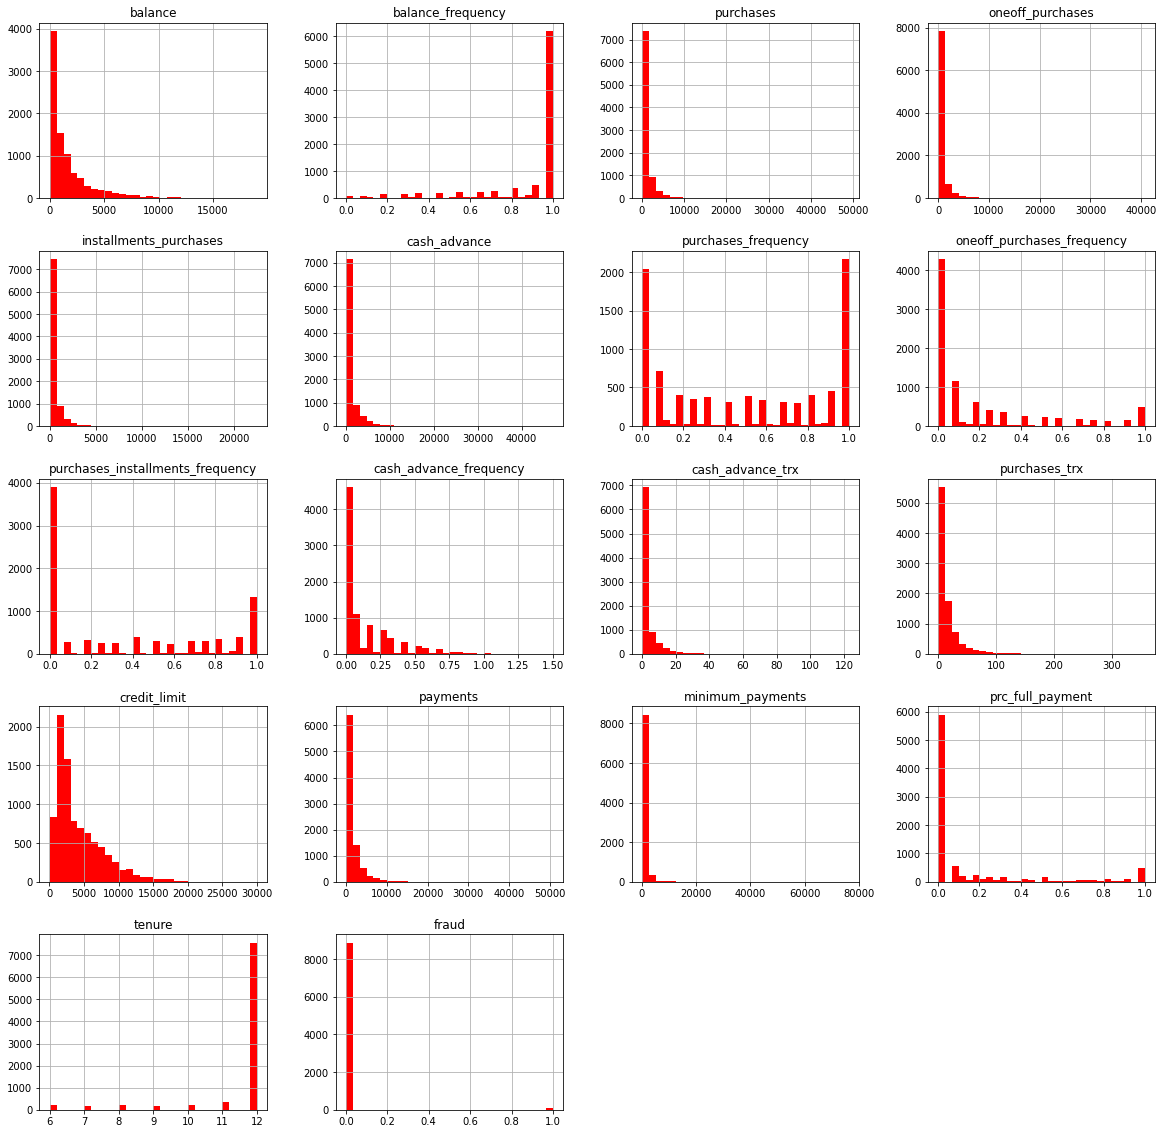

In [119]:
df.hist( bins = 30, figsize=(20,20), color='r')
plt.show()

We can see that 'tenure' column is practically constant, so we will not considere it for the classification model.

Now, we are going to make boxplot for each column.

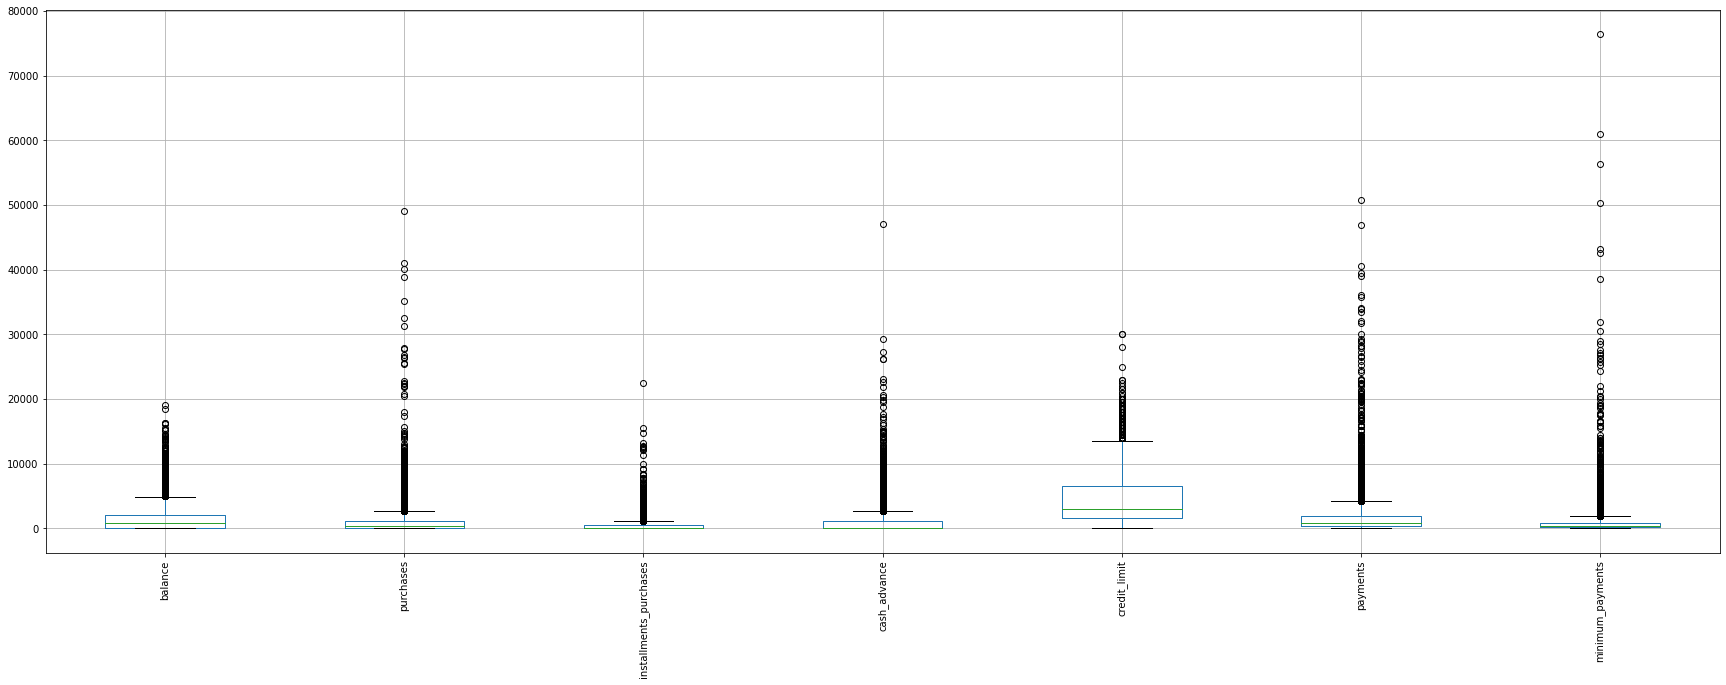

In [120]:
plt.figure(figsize = (30,10))
df[['balance', 'purchases',  'installments_purchases', 'cash_advance', 'credit_limit', 'payments', 'minimum_payments']].boxplot()
plt.xticks(rotation= 90)
plt.show()

In fact we can see that the dataset is extremly unbalanced. There are many outliers. 'istallments_purchases' column has many outliers and is also  correlated with 'purchases' column, so we will not considere it for the model.


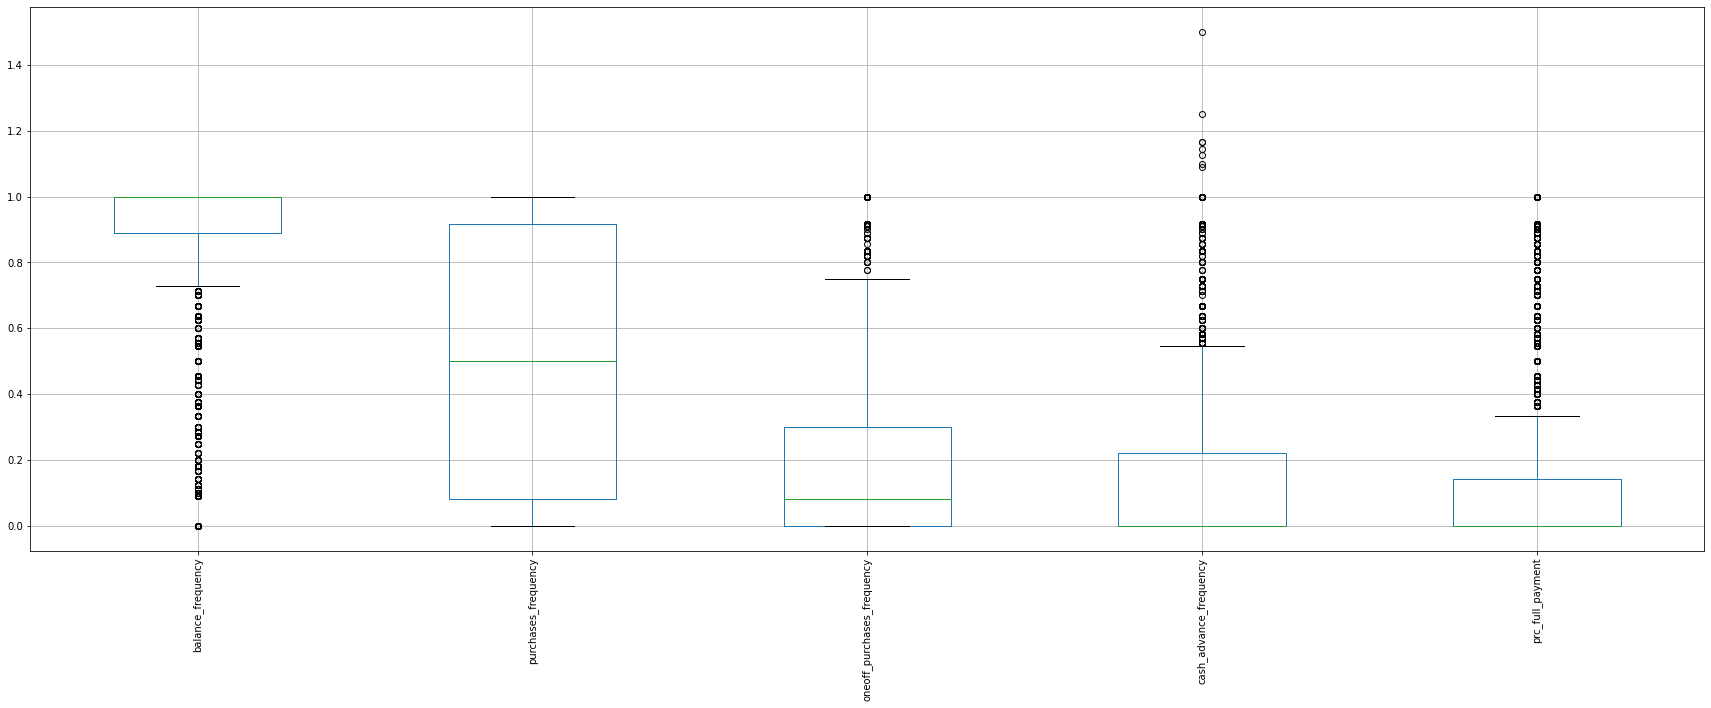

In [122]:
plt.figure(figsize = (30,10))
df[['balance_frequency', 'purchases_frequency', 'oneoff_purchases_frequency', 'cash_advance_frequency', 'prc_full_payment']].boxplot()
plt.xticks(rotation= 90)
plt.show()

In this case 'cash_advance_frequency' column is correlated with 'cash_advance' and 'cash_advance_trx'. Again, we will not considere it for the model.

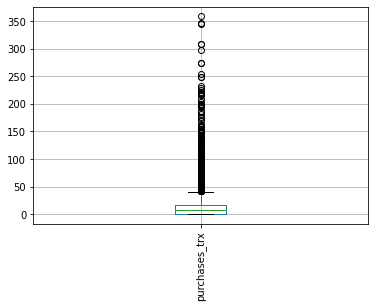

In [123]:

df[['purchases_trx']].boxplot()
plt.xticks(rotation= 90)
plt.show()

'purchases_trx' column has many many outliers and is correlated with 'purchases' and 'installments_purchases'.

Due to the previous analysis, we think that the following columns should be excluded from the model:

In [124]:
redundant_columns = {'oneoff_purchases', 'purchases_installments_frequency', 'cash_advance_trx', 'tenure', 'installments_purchases', 'cash_advance_frequency', 'purchases_trx'}

So, we will considerer the followig columns:


In [125]:
columns_to_consider = list( set(df.columns) - redundant_columns)

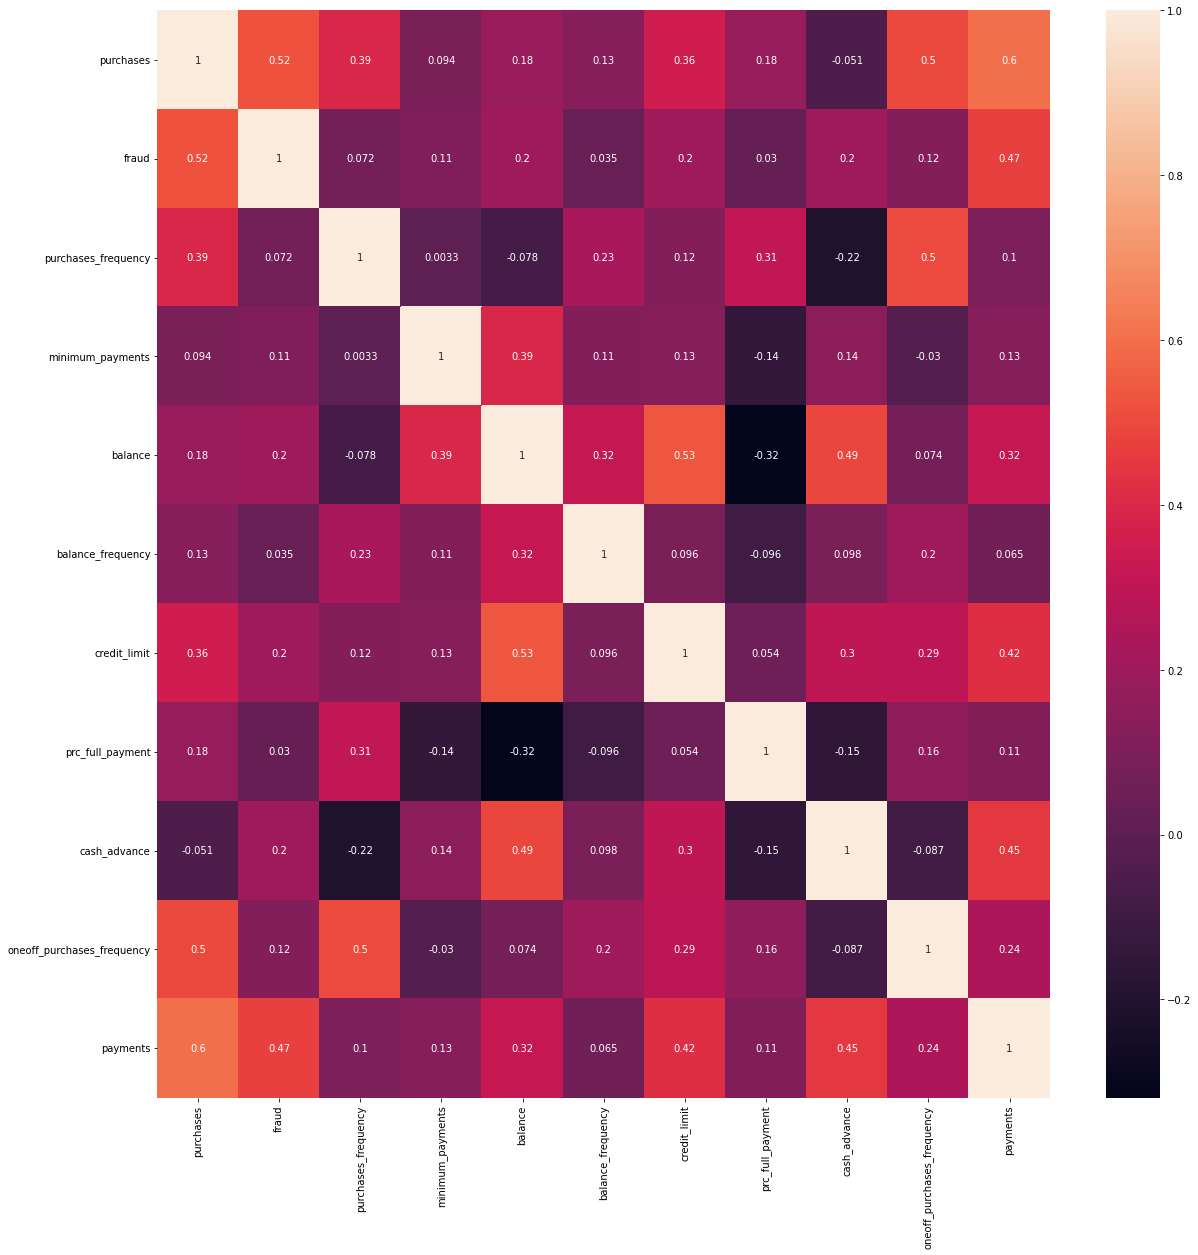

In [126]:
correlations = df[columns_to_consider].corr()
f, ax = plt.subplots( figsize = ( 20, 20 ) ) #Donde hay 1 son las variables con mayor correlacion
sns.heatmap( correlations, annot = True )
plt.show()

We can see that there are not correlated columns.

### Question 1

#### 1.1 Plot an histogram of the balance amount for all the customers.

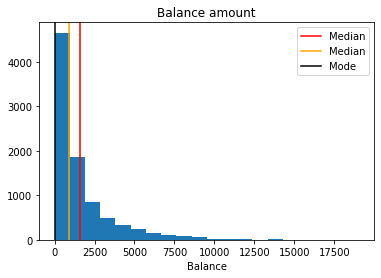

In [127]:
plt.hist(df['balance'], bins = 20)
plt.axvline(df['balance'].mean(), color = 'r', label = 'Median')
plt.axvline(df['balance'].median(), color = 'orange', label = 'Median')
plt.axvline(mode(df['balance'] ), color = 'black', label = 'Mode')
plt.xlabel('Balance')
plt.title('Balance amount')
plt.legend()
plt.show()

#### 1.2 Report any structure you find and any hypotheses you have about that structure.

The 'Balance'  column has a Right-skewed distribution. We believe that there is a relationship between the average balance and whether or not the customer is fraudulent.

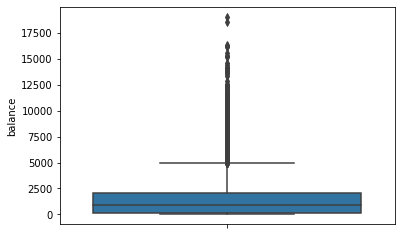

In [128]:
sns.boxplot(data = df, y = 'balance')
plt.show()

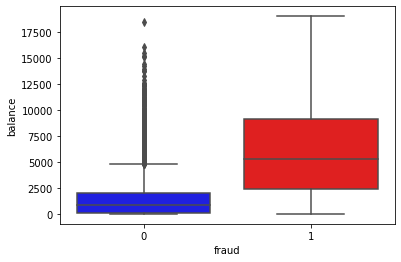

In [129]:
sns.boxplot( x = 'fraud', y = 'balance', data = df, palette = ['b', 'r'])
plt.show()

Non-fraudulent customers have all the outliers.

We can notice something interesting. Balance average for purchases is higher in people who committed fraud than in people who did not commit fraud. So we can ask ourselves, Is there any significat difference between both averages?

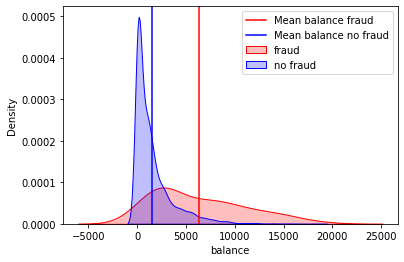

In [130]:
sns.kdeplot( df[df['fraud'] == 1]['balance'], shade = True, color = 'r', label = 'fraud')
plt.axvline(df[df['fraud'] == 1]['balance'].mean() , color = 'r', label = 'Mean balance fraud')

sns.kdeplot( df[df['fraud'] == 0]['balance'], shade = True, color = 'b', label = 'no fraud')
plt.axvline(df[df['fraud'] == 0]['balance'].mean() , color = 'b', label = 'Mean balance no fraud')
plt.legend()
plt.show()


In fact, both averages are so different. To find out if this difference is significant, we will carry out a hypothesis test.

If $\mu_f$ is the average balance for fraudulent people and $\mu_{nf}$ is the average balance for non-fraudulent people, then 
$$ H_0 : \mu_f = \mu_{nf} $$
$$ H_1 : \mu_f \neq \mu_{nf} $$

We will consider a significance $ \alpha =  0.05 $

In [131]:
fraud_balance = df[df['fraud'] == 1]['balance']


In [132]:
no_fraud_balance = df[df['fraud'] == 0]['balance']


In [133]:
t_stat, p_val = ttest_ind(fraud_balance, no_fraud_balance)
p_val

5.771791915810187e-84

The p-value is smaller than $\alpha$, so we can reject our null hypothesis $H_0$. So, there is a significant difference between both averages. So the fraudulent people have a higher balance amount for purchases.

#### 1.3 Report mean and median balance, grouped by year and month of activated_date .

In [154]:
df_balance = df[['activated_date', 'balance']].copy()

In [155]:
df_balance['activated_year'] = df_balance['activated_date'].str.split('-', expand = True)[0]
df_balance['activated_month'] = df_balance['activated_date'].str.split('-', expand = True)[1]
df_balance['activated_day'] = df_balance['activated_date'].str.split('-', expand = True)[2]

In [156]:
df_balance.drop('activated_date', axis = 1, inplace = True)

In [157]:
df_balance.head(5)

,balance,activated_year,activated_month,activated_day
1,40.900749,2019,10,06
2,3202.467416,2019,10,06
3,2495.148862,2019,10,06
4,1666.670542,2019,10,06
5,817.714335,2019,10,06


##### Mean balance by year

In [158]:
df_balance.groupby('activated_year').mean()

,balance
activated_year,
2019,2101.005577
2020,1342.433592


##### Median balance by year

In [159]:
df_balance.groupby('activated_year').median()

,balance
activated_year,
2019,1212.619649
2020,723.893169


##### Mean balance by month

In [160]:
df_balance.groupby('activated_month').mean()

,balance
activated_month,
01,1853.616296
02,1747.350977
03,1554.703952
04,1483.252293
05,1214.989637
06,939.450059
07,649.830677
10,2485.205048
11,1848.704323


##### Median balance by month

In [161]:
df_balance.groupby('activated_month').median()

,balance
activated_month,
01,1175.749847
02,994.841733
03,827.393597
04,907.371097
05,734.777480
06,472.791862
07,221.203759
10,1525.458146
11,1082.071173


### Question 2

Report in a table the following information for customers who activated their account and made their last payment during 2020: cust_id (excluding letters), activated_date (in format YYYY-MM), last_payment_date (in format YYYY-MM-DD), cash_advance , credit_limit , and a calculated field of cash_advance as a percentage of credit_limit .

In [162]:
df_report = df[['cust_id', 'activated_date', 'last_payment_date', 'cash_advance', 'credit_limit']].copy()

In [163]:
df_report['cust_id'] = df_report['cust_id'].str[1:]

In [164]:
df_report['activated_date'] = df_report['activated_date'].str[:7]

In [165]:
df_report['cash_advance_percentage'] = df_report['cash_advance'] / df_report['credit_limit'] * 100

In [166]:
df_report.head(5)

,cust_id,activated_date,last_payment_date,cash_advance,credit_limit,cash_advance_percentage
1,10001,2019-10,2020-09-09,0.000000,1000.0,0.000000
2,10002,2019-10,2020-07-04,6442.945483,7000.0,92.042078
3,10003,2019-10,2020-09-17,0.000000,7500.0,0.000000
4,10004,2019-10,2020-08-24,205.788017,7500.0,2.743840
5,10005,2019-10,2020-10-20,0.000000,1200.0,0.000000


### Relation between fraud and dates

We will analyze the fraud relationship with the dates. We believe that fraudulent people activate their credit cards on an specific date.

In [134]:
df_fraud_date = df[['cust_id', 'activated_date', 'last_payment_date',  'balance', 'fraud']].copy()

We will separate the dates in years, months and the day of the week

In [135]:
df_fraud_date['activated_year'] = df_fraud_date['activated_date'].str.split('-', expand = True)[0]
df_fraud_date['activated_month'] = df_fraud_date['activated_date'].str.split('-', expand = True)[1]
df_fraud_date['activated_day'] = df_fraud_date['activated_date'].str.split('-', expand = True)[2]

df_fraud_date['payment_year'] = df_fraud_date['last_payment_date'].str.split('-', expand = True)[0]
df_fraud_date['payment_month'] = df_fraud_date['last_payment_date'].str.split('-', expand = True)[1]
df_fraud_date['payment_day'] = df_fraud_date['last_payment_date'].str.split('-', expand = True)[2]

Lets rename the months

In [136]:
df_fraud_date['activated_month'] = df_fraud_date['activated_month'].map({
    '01': 'Jan',
    '02': 'Feb',
    '03': 'Mar',
    '04': 'Apr',
    '05': 'May',
    '06': 'Jun',
    '07': 'Jul',
    '08': 'Aug',
    '09': 'Sep',
    '10': 'Oct',
    '11': 'Nov',
    '12': 'Dec'
})

df_fraud_date['payment_month'] = df_fraud_date['payment_month'].map({
    '01': 'Jan',
    '02': 'Feb',
    '03': 'Mar',
    '04': 'Apr',
    '05': 'May',
    '06': 'Jun',
    '07': 'Jul',
    '08': 'Aug',
    '09': 'Sep',
    '10': 'Oct',
    '11': 'Nov',
    '12': 'Dec'
})

In [137]:
df_fraud_date['activated_date'] = pd.to_datetime(df_fraud_date['activated_date'])

df_fraud_date['last_payment_date'] = pd.to_datetime(df_fraud_date['last_payment_date'])


In [138]:
df_fraud_date['activated_day_of_week'] = df_fraud_date['activated_date'].dt.dayofweek

df_fraud_date['payment_day_of_week'] = df_fraud_date['last_payment_date'].dt.dayofweek

Let rename the days of the week

In [139]:
df_fraud_date['activated_day_of_week'] = df_fraud_date['activated_day_of_week'].map({
    0: 'Sun',
    1: 'Mon',
    2: 'Tue',
    3: 'Wed',
    4: 'Thu',
    5: 'Fri',
    6: 'Sat'
})

df_fraud_date['payment_day_of_week'] = df_fraud_date['payment_day_of_week'].map({
    0: 'Sun',
    1: 'Mon',
    2: 'Tue',
    3: 'Wed',
    4: 'Thu',
    5: 'Fri',
    6: 'Sat'
})

In [140]:
df_fraud_date.drop(['activated_day', 'payment_day', 'payment_year', 'activated_year'], axis = 1, inplace = True)



In [141]:
df_fraud_date.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8928 entries, 1 to 8950
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   cust_id                8928 non-null   object        
 1   activated_date         8928 non-null   datetime64[ns]
 2   last_payment_date      8928 non-null   datetime64[ns]
 3   balance                8928 non-null   float64       
 4   fraud                  8928 non-null   int64         
 5   activated_month        8928 non-null   object        
 6   payment_month          8928 non-null   object        
 7   activated_day_of_week  8928 non-null   object        
 8   payment_day_of_week    8928 non-null   object        
dtypes: datetime64[ns](2), float64(1), int64(1), object(5)
memory usage: 955.5+ KB


In [142]:
df_fraud_date.head(5)

,cust_id,activated_date,last_payment_date,balance,fraud,activated_month,payment_month,activated_day_of_week,payment_day_of_week
1,C10001,2019-10-06,2020-09-09,40.900749,0,Oct,Sep,Sat,Tue
2,C10002,2019-10-06,2020-07-04,3202.467416,0,Oct,Jul,Sat,Fri
3,C10003,2019-10-06,2020-09-17,2495.148862,0,Oct,Sep,Sat,Wed
4,C10004,2019-10-06,2020-08-24,1666.670542,0,Oct,Aug,Sat,Sun
5,C10005,2019-10-06,2020-10-20,817.714335,0,Oct,Oct,Sat,Mon


We are interested in fraudulent people:

In [143]:
df_fraud = df_fraud_date[ df_fraud_date['fraud'] == 1 ]

In [188]:
print('People who commit fraud are: {} of {}'.format(len(df_fraud) , len(df_fraud_date)))

People who commit fraud are: 70 of 8928


In [189]:
print('The percentage of people who commit fraud is: {} %'.format( round(len(df_fraud) / len(df_fraud_date) * 100, 2) ))

The percentage of people who commit fraud is: 0.78 %


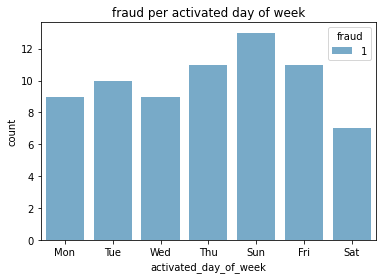

In [146]:
sns.countplot(x = 'activated_day_of_week', hue = 'fraud', data = df_fraud, palette = 'Blues')
plt.title('fraud per activated day of week')
plt.show()

We see that people who commit fraud tend to activate their card on Sunday. But we don't think the difference is really significant, let's check this out.

In [147]:
crosstab_day = pd.crosstab(df_fraud_date['activated_day_of_week'], df_fraud_date['fraud'])
_, pval, _, _ = chi2_contingency(crosstab_day)
pval

0.9124340046762454

Indeed, the p value is greater than the level of significance (0.05), so we cannot conclude that the day of the week on which the cards are activated is decisive.

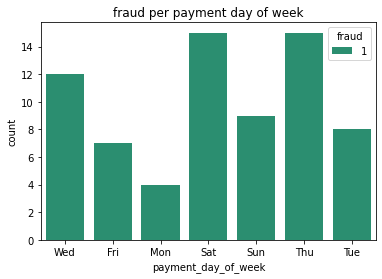

In [148]:
sns.countplot(x = 'payment_day_of_week', hue = 'fraud', data = df_fraud, palette = 'Dark2')
plt.title('fraud per payment day of week')
plt.show()

We see that most of the people committing fraud made their last payment on Saturday and Thursday. But we don't think the difference is really significant, let's see this.

In [149]:
crosstab_day = pd.crosstab(df_fraud_date['payment_day_of_week'], df_fraud_date['fraud'])
_, pval, _, _ = chi2_contingency(crosstab_day)
pval

0.14202625556845763

Again, the p value is greater than the level of significance (0.05), so we cannot conclude that the day of the week on which was the last payment is decisive.

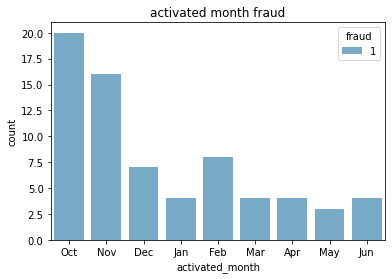

In [150]:
sns.countplot(x = 'activated_month', hue = 'fraud', data =  df_fraud, palette = 'Blues' )
plt.title('activated month fraud')
plt.show()

In the case of the month we see a clear trend, people detected as fraud tend to activate their credit card in October. Here we believe that this can be relevant

In [151]:
crosstab_month = pd.crosstab(df_fraud_date['activated_month'], df_fraud_date['fraud'])
_, pval, _, _ = chi2_contingency(crosstab_month)
pval

1.275074465271579e-08


The p value is very small so we can say that the month in which the cards are activated is relevant for people who commit fraud.

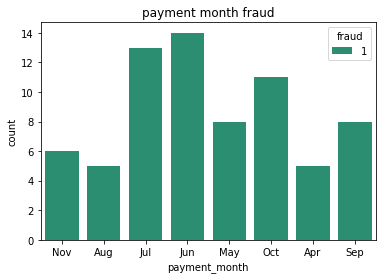

In [152]:
sns.countplot(x = 'payment_month', hue = 'fraud', data =  df_fraud, palette = 'Dark2' )
plt.title('payment month fraud')
plt.show()

In [153]:
crosstab_month = pd.crosstab(df_fraud_date['payment_month'], df_fraud_date['fraud'])
_, pval, _, _ = chi2_contingency(crosstab_month)
pval

0.08652566250885828

In contrast, since the p-value is large, the month of the last payment is of no relevance to fraudsters.

So, with this analysis, we should consider the month in which the cards are activated for our model.

### Question 3

#### 3.1 Build a predictive model for fraud.





In [167]:
df_model = df[df.columns].copy()

In [168]:
month_day = df_fraud_date[['cust_id', 'activated_month']]
month_day

,cust_id,activated_month
1,C10001,Oct
2,C10002,Oct
3,C10003,Oct
4,C10004,Oct
5,C10005,Oct
...,...,...
8946,C19186,Jul
8947,C19187,Jul
8948,C19188,Jul
8949,C19189,Jul


In [169]:
df_model = df_model.merge(month_day, on = 'cust_id')

In [170]:
df_model.head(5)

,cust_id,activated_date,last_payment_date,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,purchases_frequency,oneoff_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,cash_advance_trx,purchases_trx,credit_limit,payments,minimum_payments,prc_full_payment,tenure,fraud,activated_month
0,C10001,2019-10-06,2020-09-09,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12,0,Oct
1,C10002,2019-10-06,2020-07-04,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12,0,Oct
2,C10003,2019-10-06,2020-09-17,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12,0,Oct
3,C10004,2019-10-06,2020-08-24,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,864.173246,0.000000,12,0,Oct
4,C10005,2019-10-06,2020-10-20,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12,0,Oct


As stated, for our model, the month in which the cards were activated will be considered. Since it is a categorical variable, we will transform it using one hot encoding

In [171]:
categorical =  df_model[['activated_month']]

In [172]:
df_categorical = pd.DataFrame(OneHotEncoder().fit_transform( categorical ).toarray())

In [173]:
df_categorical.head(5)

,0,1,2,3,4,5,6,7,8,9
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [174]:
df_model = pd.concat([ df_categorical, df_model ], axis = 1 )
df_model.head(5)

,0,1,2,3,4,5,6,7,8,9,cust_id,activated_date,last_payment_date,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,purchases_frequency,oneoff_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,cash_advance_trx,purchases_trx,credit_limit,payments,minimum_payments,prc_full_payment,tenure,fraud,activated_month
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,C10001,2019-10-06,2020-09-09,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12,0,Oct
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,C10002,2019-10-06,2020-07-04,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12,0,Oct
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,C10003,2019-10-06,2020-09-17,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12,0,Oct
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,C10004,2019-10-06,2020-08-24,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,864.173246,0.000000,12,0,Oct
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,C10005,2019-10-06,2020-10-20,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12,0,Oct


#### The model

We will consider the following classification models. Afterwards, we will use the recall score to select the best one. We believe that this metric is the most appropriate because in this problem the data is unbalanced (only 1% has been detected as fraud), so the accuracy is not adequate. Instead, it is important to minimize false negatives.

In [175]:
classifiers = {'Naive': GaussianNB(), 
               'Logisitic': LogisticRegression(), 
               'SVM': SVC(probability = True), 
               'Decision Tree': DecisionTreeClassifier(), 
               'KNearest': KNeighborsClassifier(),
               'SGD': SGDClassifier( loss = 'log' ),
               #'ridge': RidgeClassifier(),
               'bagging': BaggingClassifier(),
               'random forest': RandomForestClassifier(n_estimators=10),
               'ADABoost': AdaBoostClassifier(),
               'XGBoost': XGBClassifier()
               }

We define the collumnes to exclude

In [193]:
columns_exclude = {'cust_id', 
                   'activated_date', 
                   'last_payment_date', 
                   'activated_month', 
                   'activated_day_of_week', 
                   'fraud'}.union(redundant_columns)

In [194]:
columns_exclude

{'activated_date',
 'activated_day_of_week',
 'activated_month',
 'cash_advance_frequency',
 'cash_advance_trx',
 'cust_id',
 'fraud',
 'installments_purchases',
 'last_payment_date',
 'oneoff_purchases',
 'purchases_installments_frequency',
 'purchases_trx',
 'tenure'}

We define the target feature:

In [178]:
target = 'fraud'

We are going to build a function that iterates over our list of models, makes the predictions and prints a roc plot, the confusion matrix and the metrics f1 score, precision score and recall score

In [179]:

def models(data, classifiers, columns_exclude, target):
  columns = list(set(data.columns) - columns_exclude )
  X = data[columns].values
  X = StandardScaler().fit_transform(X)

  y = data[ target ]

  X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.20 )

  for classifier in classifiers:
    classifiers[classifier].fit(X_train, y_train)
    y_pred = classifiers[classifier].predict(X_test)
    print('\n***** ' + classifier + ' ***** \n')
    print("Accuracy", accuracy_score(y_test, y_pred))
    print("\nF1 score", f1_score(y_test, y_pred))
    print("\nPrecision score", precision_score(y_test, y_pred))
    print("\nRecall score", recall_score(y_test, y_pred))


    fig = plt.figure(figsize = (15,5)) 
    ax1 = fig.add_subplot(1, 2, 1) 
    ax2 = fig.add_subplot(1, 2, 2)

    y_pred_proba = classifiers[classifier].predict_proba(X_test)[::,1]
    fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    ax1.plot(fpr,tpr,label="data 1, auc=" + str(auc))
    ax1.legend(loc=4)

    cf_matrix = confusion_matrix(y_test, y_pred)
    ax2 = sns.heatmap(cf_matrix, annot=True, cmap='Blues')
    ax2.set_title('Confusion Matrix\n\n');
    ax2.set_xlabel('\nPredicted Values')
    ax2.set_ylabel('Actual Values ');
    ax2.xaxis.set_ticklabels(['False','True'])
    ax2.yaxis.set_ticklabels(['False','True'])

    plt.show()


***** Naive ***** 

Accuracy 0.8297872340425532

F1 score 0.07878787878787878

Precision score 0.04126984126984127

Recall score 0.8666666666666667


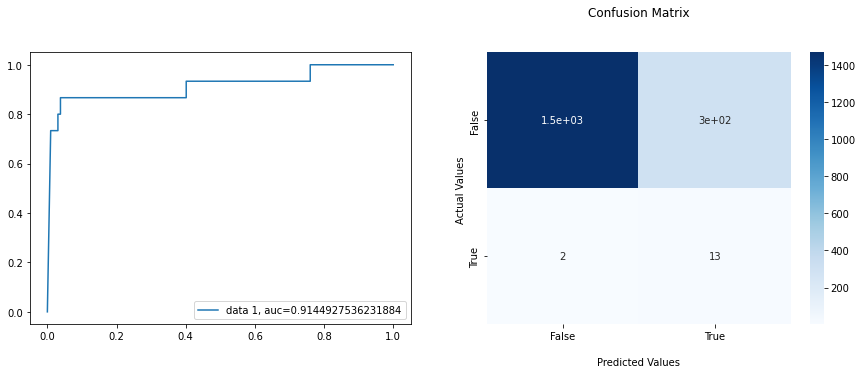


***** Logisitic ***** 

Accuracy 0.9955207166853304

F1 score 0.6666666666666667

Precision score 0.8888888888888888

Recall score 0.5333333333333333


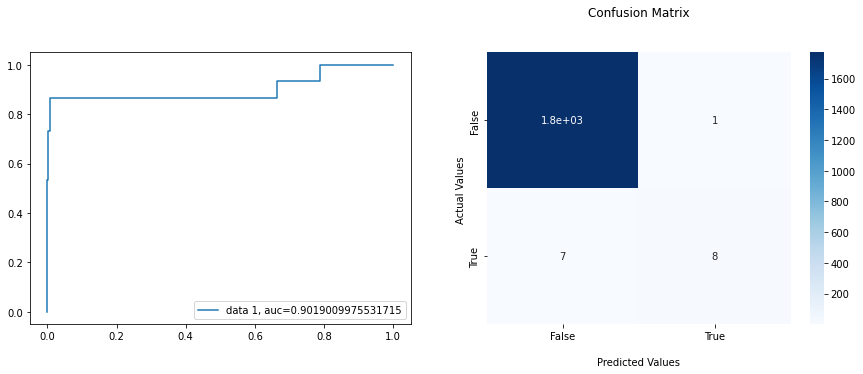


***** SVM ***** 

Accuracy 0.9927211646136618

F1 score 0.31578947368421056

Precision score 0.75

Recall score 0.2


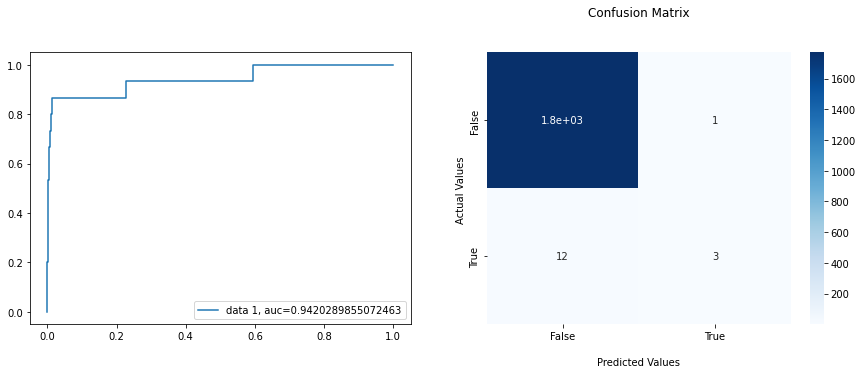


***** Decision Tree ***** 

Accuracy 0.9916013437849944

F1 score 0.4444444444444445

Precision score 0.5

Recall score 0.4


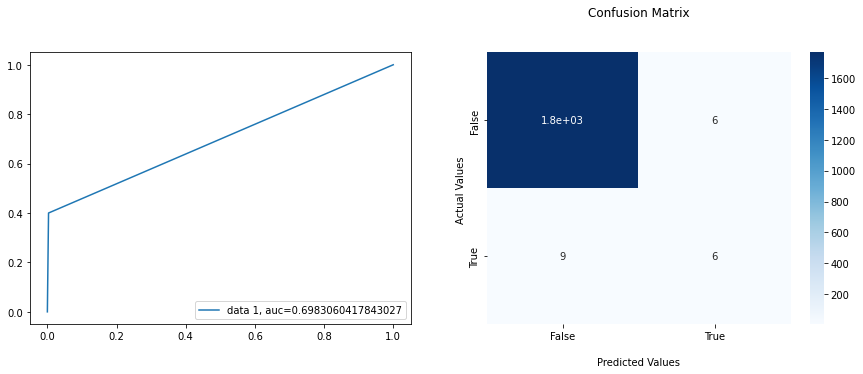


***** KNearest ***** 

Accuracy 0.9944008958566629

F1 score 0.5

Precision score 1.0

Recall score 0.3333333333333333


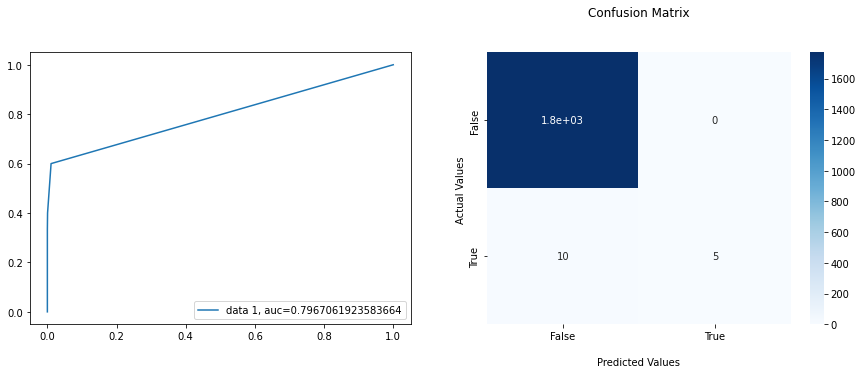


***** SGD ***** 

Accuracy 0.9955207166853304

F1 score 0.6666666666666667

Precision score 0.8888888888888888

Recall score 0.5333333333333333


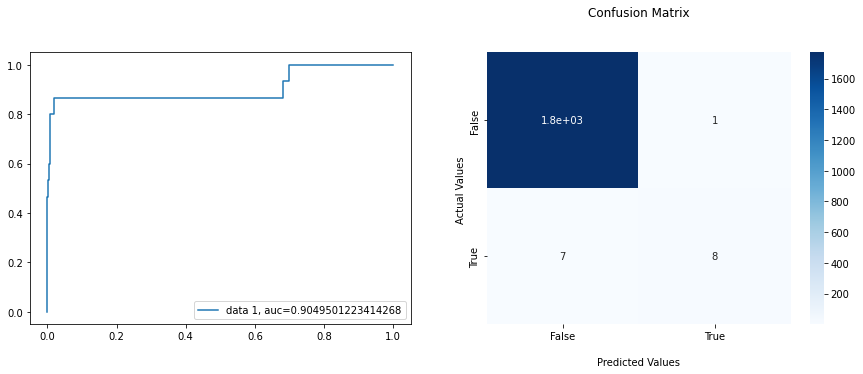


***** bagging ***** 

Accuracy 0.9927211646136618

F1 score 0.43478260869565216

Precision score 0.625

Recall score 0.3333333333333333


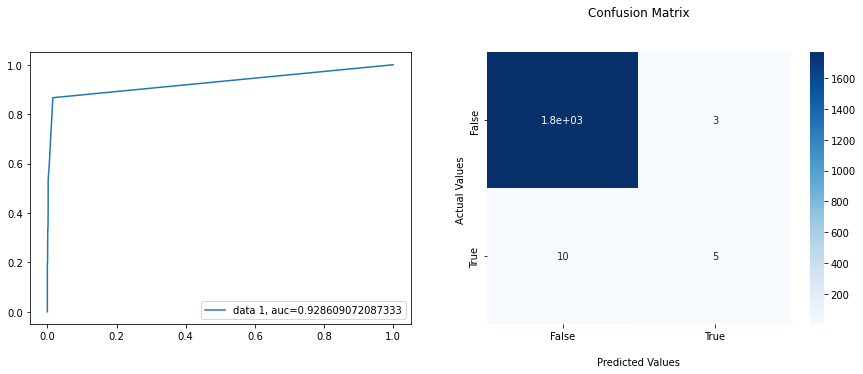


***** random forest ***** 

Accuracy 0.9938409854423292

F1 score 0.4210526315789474

Precision score 1.0

Recall score 0.26666666666666666


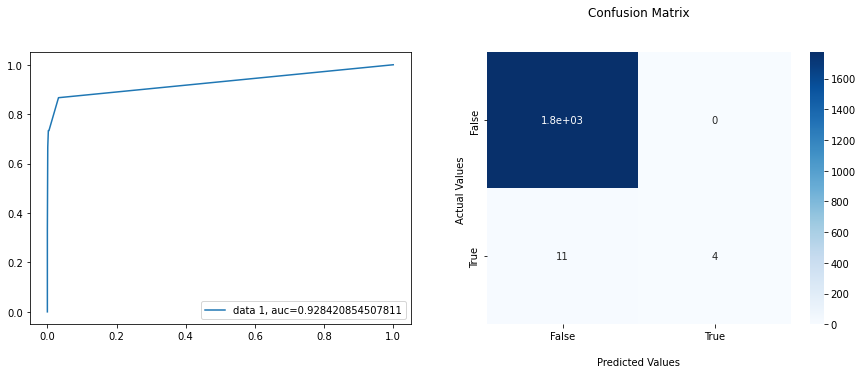


***** ADABoost ***** 

Accuracy 0.9944008958566629

F1 score 0.5454545454545455

Precision score 0.8571428571428571

Recall score 0.4


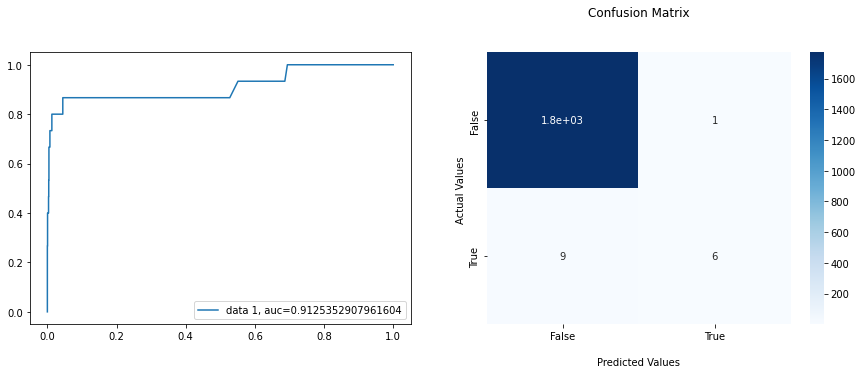


***** XGBoost ***** 

Accuracy 0.9938409854423292

F1 score 0.5217391304347827

Precision score 0.75

Recall score 0.4


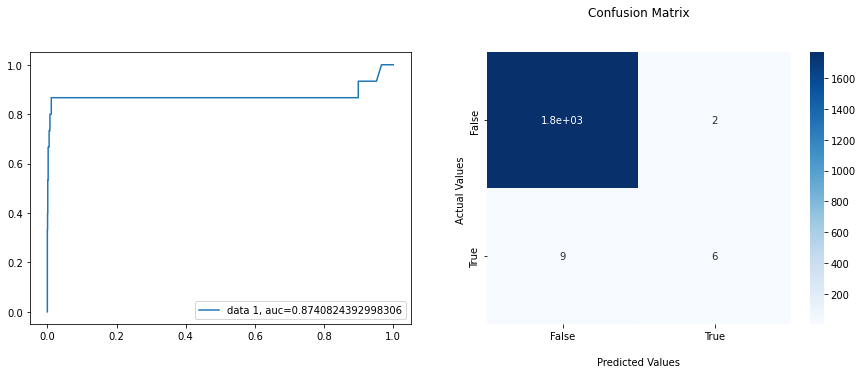

In [180]:
models(df_model, classifiers, columns_exclude, target)

We see that Naive-Bayes is the best option for this case bacause it has the highest recall score and minimize the number of false negatives. This is important because in this way we minimize the number of people who commit undetected fraud .

#### Oversampling

As we said, the data is unbalanced, so we will apply an oversampling technique to compensate for this and be able to consider the rest of the metrics and have a better model.

In [181]:
count_class_0, count_class_1 = df_model.fraud.value_counts()

# Divide by class
df_class_0 = df_model[df_model['fraud'] == 0]
df_class_1 = df_model[df_model['fraud'] == 1]

Random over-sampling:
0    8858
1    8858
Name: fraud, dtype: int64


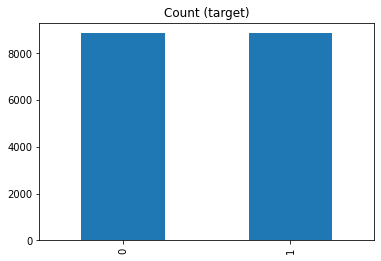

In [182]:
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_test_over.fraud.value_counts())

df_test_over.fraud.value_counts().plot(kind='bar', title='Count (target)')

In [183]:
df_test_over.head(5)

,0,1,2,3,4,5,6,7,8,9,cust_id,activated_date,last_payment_date,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,purchases_frequency,oneoff_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,cash_advance_trx,purchases_trx,credit_limit,payments,minimum_payments,prc_full_payment,tenure,fraud,activated_month
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,C10001,2019-10-06,2020-09-09,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12,0,Oct
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,C10002,2019-10-06,2020-07-04,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12,0,Oct
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,C10003,2019-10-06,2020-09-17,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12,0,Oct
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,C10004,2019-10-06,2020-08-24,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,864.173246,0.000000,12,0,Oct
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,C10005,2019-10-06,2020-10-20,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12,0,Oct



***** Naive ***** 

Accuracy 0.748589164785553

F1 score 0.779182156133829

Precision score 0.6894736842105263

Recall score 0.8957264957264958


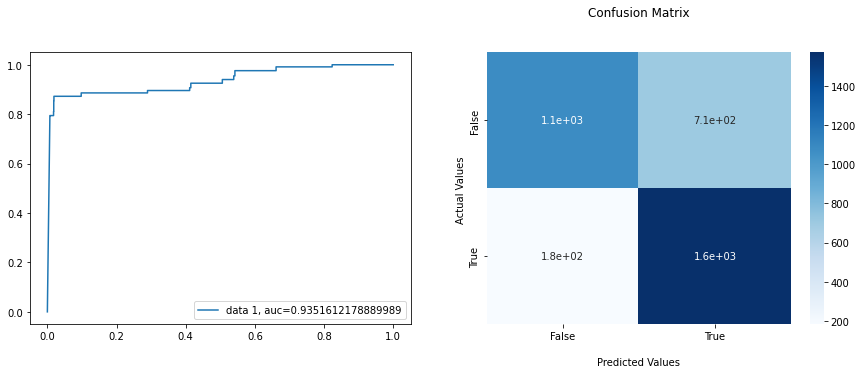


***** Logisitic ***** 

Accuracy 0.9068848758465011

F1 score 0.9027122641509434

Precision score 0.935247403787416

Recall score 0.8723646723646724


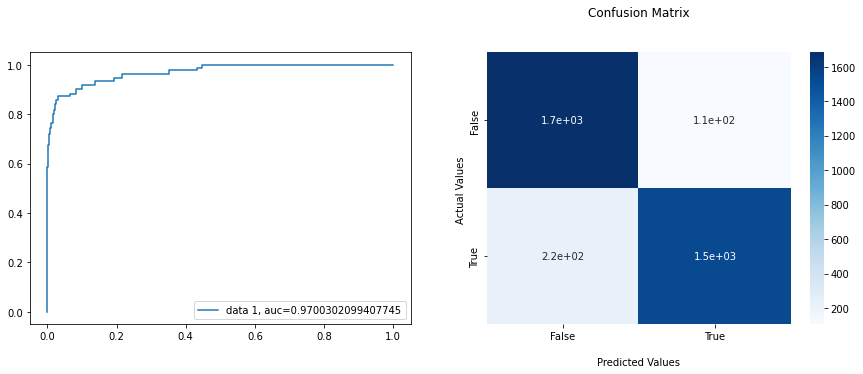


***** SVM ***** 

Accuracy 0.9647291196388262

F1 score 0.963924963924964

Precision score 0.9766081871345029

Recall score 0.9515669515669516


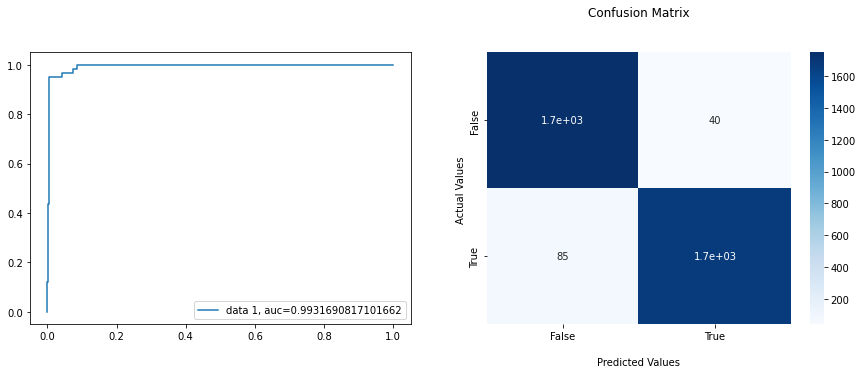


***** Decision Tree ***** 

Accuracy 0.998589164785553

F1 score 0.9985775248933144

Precision score 0.9971590909090909

Recall score 1.0


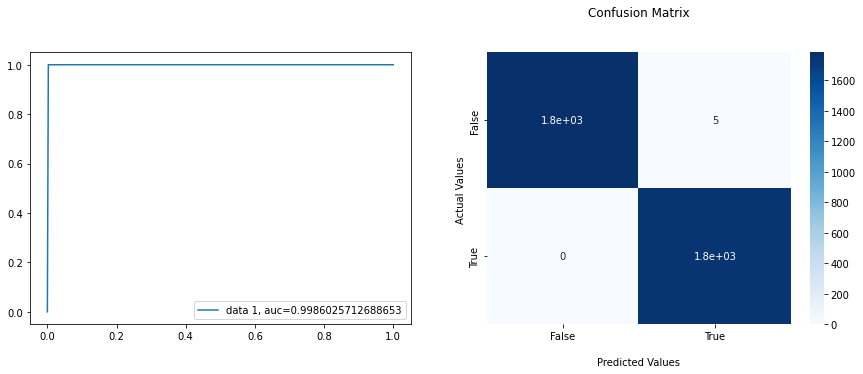


***** KNearest ***** 

Accuracy 0.9974604966139955

F1 score 0.9974424552429668

Precision score 0.9948979591836735

Recall score 1.0


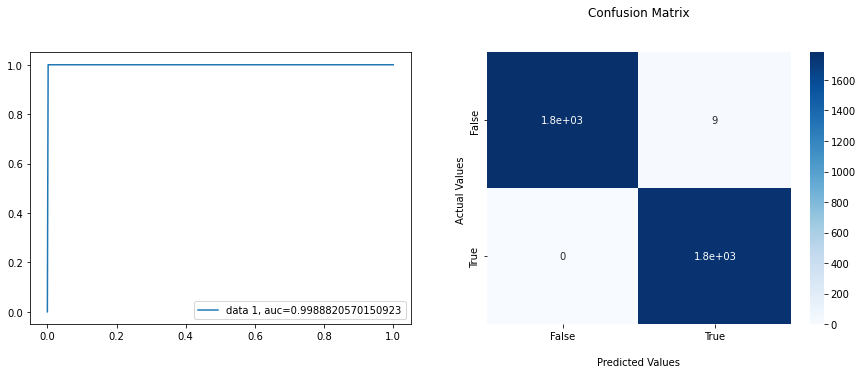


***** SGD ***** 

Accuracy 0.9085778781038375

F1 score 0.9043118724158299

Precision score 0.9386879215205396

Recall score 0.8723646723646724


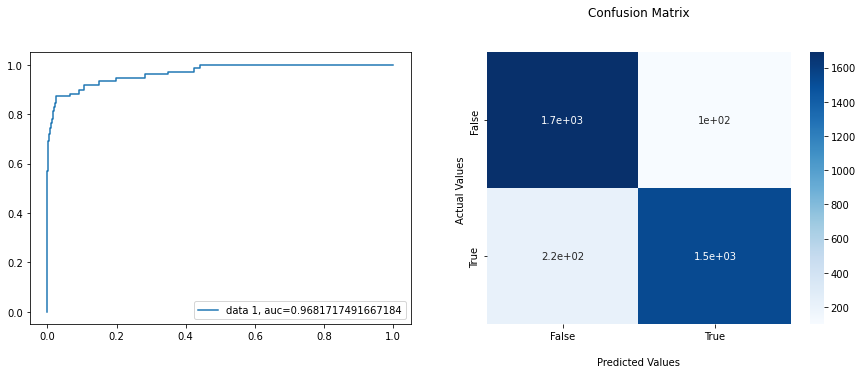


***** bagging ***** 

Accuracy 0.9991534988713319

F1 score 0.9991460290350128

Precision score 0.9982935153583617

Recall score 1.0


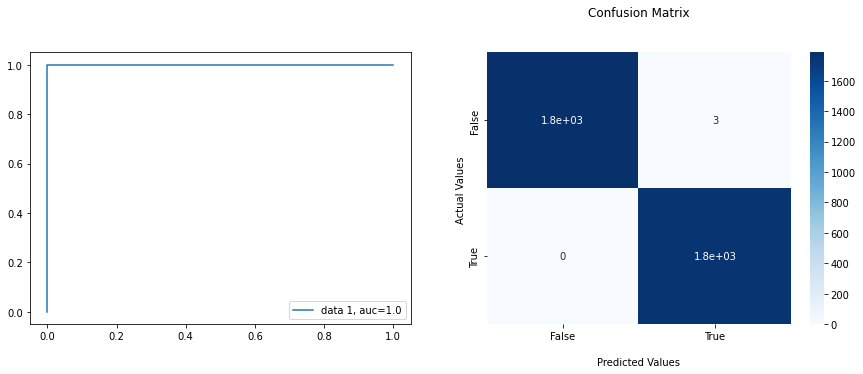


***** random forest ***** 

Accuracy 0.9997178329571106

F1 score 0.9997151808601538

Precision score 0.9994305239179955

Recall score 1.0


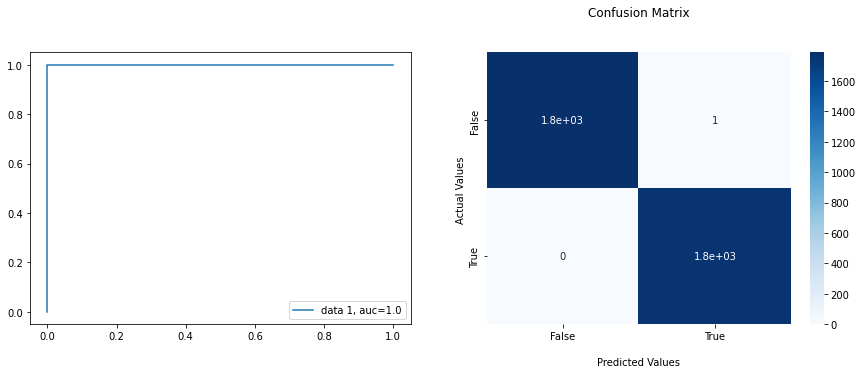


***** ADABoost ***** 

Accuracy 0.9808126410835214

F1 score 0.9806488332384747

Precision score 0.9795338260375214

Recall score 0.9817663817663818


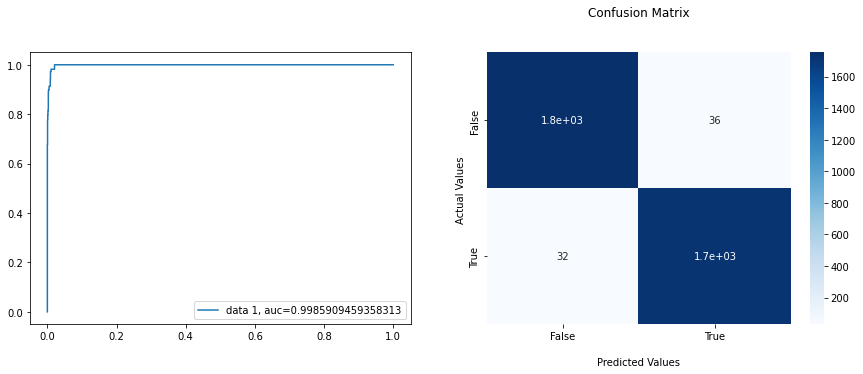


***** XGBoost ***** 

Accuracy 0.9954853273137697

F1 score 0.9954622802041975

Precision score 0.9909655561829475

Recall score 1.0


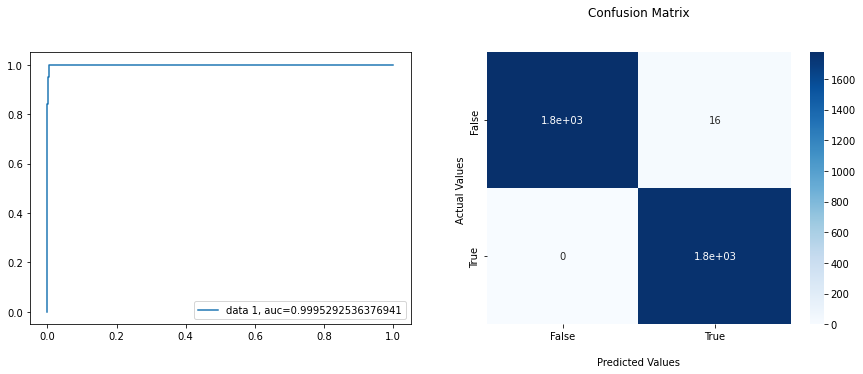

In [184]:
models(df_test_over, classifiers, columns_exclude, target)

As we can see now, the recall score reaches the value of 1. That is, we minimize the number of people who commit undetected fraud. The algorithms XGBoost, Random Forest, Bagging, Knearest, Decision Tree have a recall score of 1. Of all these, the best algorithm is Random Forest because it has an f1 score of 0.999.

#### 3.2 What explanatory variable was the most powerful predictor for fraud?

 We think that there are several variables that influence whether a person commits fraud. One of them, as mentioned, is the month of activation of the card. Another is the balance for purchases and finally the purchases made.